
# 2018_climate4R_example1

***
There is a [PDF version](https://github.com/SantanderMetGroup/notebooks/blob/master/2018_climate4R_example1.pdf) of this notebook.
***

This worked example contains the full code that reproduces the 1rst example of the paper "climate4R: An R-based Framework for Climate Data Access, Post-processing and Bias Correction" (Sec. 5 of the manuscript). Here, the same titles are used for the main sections (see index). These are divided in additional subsections to help with the understanding of the different code chunks. All operations hereinafter are performed with the core packages of climate4R, excepting package installation and the creation of color palettes, for which packages `devtools` and `RColorBrewer` are used respectively.



climate4R packages are installed by means of the `devtools' package:


In [1]:
library(loadeR)
library(transformeR)
library(visualizeR)
library(downscaleR)
library(climate4R.climdex)

Loading required package: rJava
Loading required package: loadeR.java
Java version 1.8x amd64 by Oracle Corporation detected
NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready
loadeR version 1.4.8 (2018-09-23) is loaded
Please use 'citation("loadeR")' to cite this package.
transformeR version 1.4.7 (2018-10-20) is loaded
Development version may have an unexpected behaviour
Please see 'citation("transformeR")' to cite this package.
Loading required package: sm
Warning message:
“no DISPLAY variable so Tk is not available”Package 'sm', version 2.2-5.6: type help(sm) for summary information
visualizeR version 1.3.0 (2018-10-17) is loaded

Attaching package: ‘visualizeR’

The following objects are masked from ‘package:transformeR’:

    clim2sgdf, map.lines, map.stippling

Loading required package: deepnet
Loading required package: glmnet
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

downscaleR version 3.0.4 (2018-09-23) is loaded
P

# Example 1: Climate Indices from CORDEX Projections

## Loading, collocating and harmonizing data 

The domain of the study area is defined by the following bounding coordinates:

In [2]:
lon <- c(-10, 20)
lat <- c(35, 46)

### Cliamte data loading from OPeNDAP server: E-OBS observational data 

As described in the paper, the SU index (summer days) can be obtained on-the-fly by loading maximum temperature data with function `loadGridData` and by the following argument settings: `aggr.m = "sum"`, `condition = "GT"` and `threshold = 25`. First we load E-OBS observational data by pointing to a NetCDF file via OPeNDAP. Previous to loading, function `dataInventory` might be applied for an overview of the dataset, which returns an inventory (object `di`) of the available variables names, units, coordinates, etc.  


In [3]:
eobs<-"http://opendap.knmi.nl/knmi/thredds/dodsC/e-obs_0.25regular/tx_0.25deg_reg_v17.0.nc"
di <- dataInventory(eobs)

[2018-12-13 12:46:05] Doing inventory ...
[2018-12-13 12:46:08] Retrieving info for 'tx' (0 vars remaining)
[2018-12-13 12:46:08] Done.


In this case, the NetCDF file contains maximum temperature data named as "tx", thus, we set `var = "tx"` when calling to `loadGridData`:

In [4]:
SU <- loadGridData(eobs, var = "tx",
                    season = 1:12, 
                    years = 1971:2000,
                    lonLim = lon, 
                    latLim = lat,
                    aggr.m = "sum", 
                    condition = "GT", 
                    threshold = 25)

[2018-12-13 12:46:08] Opening dataset...
[2018-12-13 12:46:09] The dataset was successfuly opened
[2018-12-13 12:46:09] Defining geo-location parameters
[2018-12-13 12:46:09] Defining time selection parameters
NOTE: Daily data will be monthly aggregated
[2018-12-13 12:46:09] Retrieving data subset ...
[2018-12-13 12:52:16] Done


#### Using a dictionary

In order to load and work with harmonized data we can repeat the above operation using a dictionary file, that defines the necessary name and unit transformations to the standard parameters. Function `C4R.vocabulary` displays the climate4R standard variable naming and units:


In [5]:
C4R.vocabulary()

identifier,standard_name,units
hurs,2-meter relative humidity,%
hursmax,maximum 2-meter relative humidity,%
hursmin,minimum 2-meter relative humidity,%
hus,specific humidity,kg.kg-1
huss,2-meter specific humidity,kg.kg-1
hussmax,maximum 2-meter specific humidity,kg.kg-1
hussmin,minimum 2-meter specific humidity,kg.kg-1
lm,land binary mask,1
orog,surface altitude,m
ps,air pressure at surface level,Pa


In this case, the only non-standard parameter in the E-OBS dataset is the variable name ("tx"), however, we could perform further loading requests using the standard name if a dictionary file is crated previously (see the [`loadeR` wiki](https://github.com/SantanderMetGroup/loadeR/wiki/Harmonization)). This can be done easily, for instance, in the following manner:

In [6]:
file.create("dicEOBS.dic")
writeLines(c("identifier,short_name,time_step,lower_time_bound,upper_time_bound, cell_method,offset,scale,deaccum,derived,interface",
             "tasmax,tx,24h,0,24,max,0,1,0,0,"), "dicEOBS.dic")

[1] TRUE

Next the loading operation is repeated but using the standard name for the maximum temperature (`var = "tasmax"`) and by passing the path to our *.dic file ("dicEOBS.dic") in argument `dictionary`:

In [7]:
SU <- loadGridData(eobs,
                         var = "tasmax",
                         season = 1:12,
                         lonLim = lon,
                         latLim = lat,
                         years = 1971:2000,
                         aggr.m = "sum", 
                         threshold = 25,
                         condition = "GT",
                         dictionary = "dicEOBS.dic")

[2018-12-13 12:52:16] Defining harmonization parameters for variable "tasmax"
[2018-12-13 12:52:16] Opening dataset...
[2018-12-13 12:52:17] The dataset was successfuly opened
[2018-12-13 12:52:17] Defining geo-location parameters
[2018-12-13 12:52:17] Defining time selection parameters
NOTE: Daily data will be monthly aggregated
[2018-12-13 12:52:17] Retrieving data subset ...
[2018-12-13 12:57:55] Done


#### Transformation and visualization
Note that `loadGridData` returns monthly summer days (SU). To compute the annual index we only need to apply function `aggregateGrid` that performs the aggregation of the desired data dimension (in this case `time`). We use argument `aggr.y` to perform annual aggregation with function `sum`:


In [8]:
SU.annual <- aggregateGrid(SU, aggr.y = list(FUN = "sum"))

[2018-12-13 12:57:55] Performing annual aggregation...
[2018-12-13 12:57:56] Done.


#### Transformation and visualization
Note that `loadGridData` returns monthly summer days (SU). To compute the annual index we only need to apply function `aggregateGrid` that performs the aggregation of the desired data dimension (in this case `time`). We use argument `aggr.y` to perform annual aggregation with function `sum`:

In [9]:
library(RColorBrewer)
colstx <- rev(brewer.pal(n = 9, "Spectral"))
colsindex <- rev(brewer.pal(n = 9, "RdYlBu"))
colsdelta <- brewer.pal(n = 9, "Reds")
colsbias <- brewer.pal(n = 9, "PiYG")
colssd <- brewer.pal(n = 9, "Blues")

In this case we set `col.regions = colorRampPalette(colsindex)` to visualize the mean annual SU for the reference period (1971-2000). As a result Figure \ref{fig:fig2a} is generated (Fig. 2a in the manuscript).

[2018-12-13 12:57:56] - Computing climatology...
[2018-12-13 12:57:56] - Done.


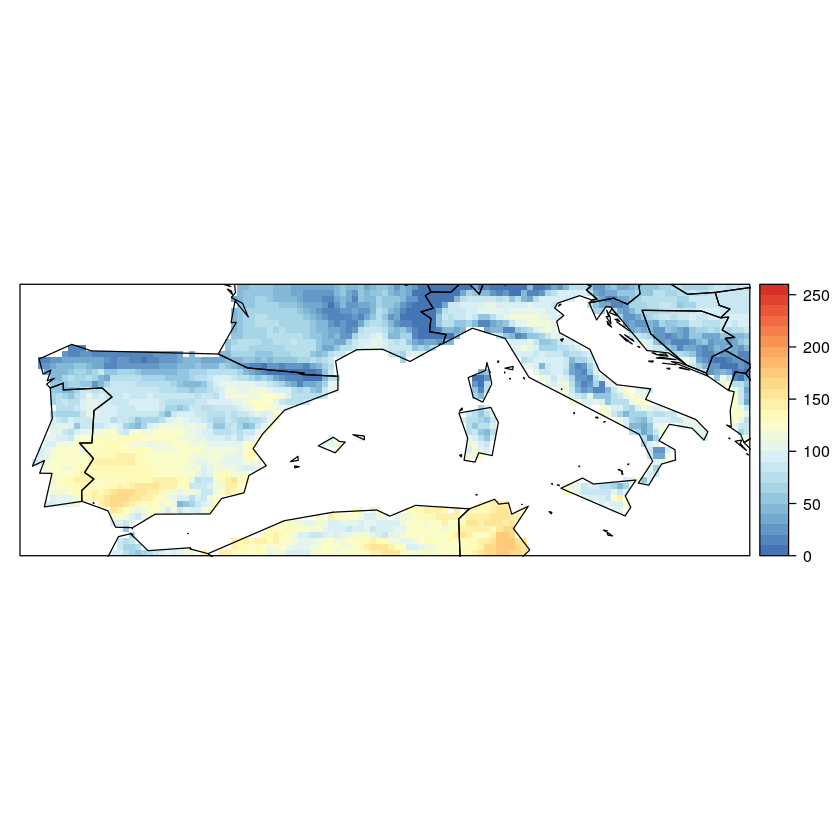

In [10]:
spatialPlot(climatology(SU.annual), backdrop.theme = "countries", 
            at = seq(0, 260, 10), col.regions = colorRampPalette(colsindex))

### Cliamte data loading from local files: CORDEX climate change projections
Next, projection data (for both the historical and the RCP8.5 scenarios) is loaded from local NetCDF files, which correspond to a particular RCM (Regional Climate Model ICHEC-EC-EARTH_r12i1p1_SMHI-RCA4_v1) from EURO-CORDEX. These files were downloaded from ESGF (see Appendix A in the manuscript) and stored locally. Next we list them in objects `dir` and `dirf`, the first corresponding to the historical scenario and the second to the future RCP8.5.

In [31]:
dir <- "local_nc_data/historical/"
dirf <- "local_nc_data/rcp85"
print(list.files(dir, recursive = T))

 [1] "tasmax_EUR-44_ICHEC-EC-EARTH_historical_r12i1p1_SMHI-RCA4_v1_day_19510101-19551231.nc"
 [2] "tasmax_EUR-44_ICHEC-EC-EARTH_historical_r12i1p1_SMHI-RCA4_v1_day_19560101-19601231.nc"
 [3] "tasmax_EUR-44_ICHEC-EC-EARTH_historical_r12i1p1_SMHI-RCA4_v1_day_19610101-19651231.nc"
 [4] "tasmax_EUR-44_ICHEC-EC-EARTH_historical_r12i1p1_SMHI-RCA4_v1_day_19660101-19701231.nc"
 [5] "tasmax_EUR-44_ICHEC-EC-EARTH_historical_r12i1p1_SMHI-RCA4_v1_day_19710101-19751231.nc"
 [6] "tasmax_EUR-44_ICHEC-EC-EARTH_historical_r12i1p1_SMHI-RCA4_v1_day_19760101-19801231.nc"
 [7] "tasmax_EUR-44_ICHEC-EC-EARTH_historical_r12i1p1_SMHI-RCA4_v1_day_19810101-19851231.nc"
 [8] "tasmax_EUR-44_ICHEC-EC-EARTH_historical_r12i1p1_SMHI-RCA4_v1_day_19860101-19901231.nc"
 [9] "tasmax_EUR-44_ICHEC-EC-EARTH_historical_r12i1p1_SMHI-RCA4_v1_day_19910101-19951231.nc"
[10] "tasmax_EUR-44_ICHEC-EC-EARTH_historical_r12i1p1_SMHI-RCA4_v1_day_19960101-20001231.nc"
[11] "tasmax_EUR-44_ICHEC-EC-EARTH_historical_r12i1p1_SMHI-RCA4_v1_day

Each file in the list contains data for a 5-year period of the same variable (tasmax). Therefore, we use a "catalog" (*.ncml file) to load data for the required period without worrying about the different files that need to be read and bound. Next we create two catalogs (for each scenario) with function `makeAggregateDataset` ("CDX_hist.ncml" and "CDX_rcp85.ncml"):

In [32]:
makeAggregatedDataset(source.dir = dir, recursive = T, ncml.file = "local_nc_data/historical/CDX_hist.ncml")
makeAggregatedDataset(source.dir = dirf, recursive = T, ncml.file = "local_nc_data/rcp85/CDX_rcp85.ncml")

[2018-12-13 13:06:35] Creating dataset from 11 files
[2018-12-13 13:06:35] Scanning file 1 out of 1
[2018-12-13 13:06:35] Defining aggregating dimension length
This process may be slow but will significantly speed-up data retrieval...
[2018-12-13 13:06:36] Dimension length defined
[2018-12-13 13:06:36] NcML file "CDX_hist.ncml" created from 11 files corresponding to 1 variables
Use 'dataInventory' to obtain a description of the dataset
[2018-12-13 13:06:36] Creating dataset from 19 files
[2018-12-13 13:06:36] Scanning file 1 out of 1
[2018-12-13 13:06:36] Defining aggregating dimension length
This process may be slow but will significantly speed-up data retrieval...
[2018-12-13 13:06:37] Dimension length defined
[2018-12-13 13:06:37] NcML file "CDX_rcp85.ncml" created from 19 files corresponding to 1 variables
Use 'dataInventory' to obtain a description of the dataset


The created *.ncml files are then used as a single access point to load data and to do the data inventory as well:

In [14]:
di <- dataInventory("local_nc_data/historical/CDX_hist.ncml")
str(di$tasmax)

[2018-12-13 13:00:12] Doing inventory ...
[2018-12-13 13:00:12] Retrieving info for 'tasmax' (0 vars remaining)
[2018-12-13 13:00:12] Done.


List of 4
 $ Description: chr "Daily Maximum Near-Surface Air Temperature"
 $ DataType   : chr "float"
 $ Units      : chr "K"
 $ Dimensions :List of 3
  ..$ time:List of 4
  .. ..$ Type      : chr "Time"
  .. ..$ TimeStep  : chr "1.0 days"
  .. ..$ Units     : chr "days since 1949-12-01 00:00:00"
  .. ..$ Date_range: chr "1951-01-01T12:00:00Z - 2005-12-31T12:00:00Z"
  ..$ lat :List of 3
  .. ..$ Type  : chr "GeoY"
  .. ..$ Units : chr "degrees"
  .. ..$ Values: num [1:103] -23.2 -22.8 -22.3 -21.9 -21.4 ...
  ..$ lon :List of 3
  .. ..$ Type  : chr "GeoX"
  .. ..$ Units : chr "degrees"
  .. ..$ Values: num [1:106] -28.2 -27.8 -27.3 -26.9 -26.4 ...


Contrarily to the case of the E-OBS dataset, the variable name is standard, but not the units (K). Therefore we define the harmonization parameters in another dictionary file ("dicCDX.dic"), where the offset is -273.15 to convert the data to the standard units (ºC):


In [15]:
file.create("local_nc_data/dicCDX.dic")
writeLines(c("identifier,short_name,time_step,lower_time_bound,upper_time_bound,cell_metod,offset,scale,deaccum,derived,interface",
             "tasmax,tasmax,24h,0,24,max,-273.15,1,0,0,"), "local_nc_data/dicCDX.dic")

[1] TRUE

#### Historical data
Next, harmonized data is loaded for a single CORDEX model, for the historical scenario and the same reference period used to load E-OBS observational data (1971-2000):

In [16]:
SUh <- loadGridData(dataset = "CDX_hist.ncml",
                     var = "tasmax",
                     season = 1:12,
                     lonLim = lon,
                     latLim = lat,
                     years = 1971:2000,
                     aggr.m = "sum",
                     threshold = 25,
                     condition = "GT",
                     dictionary = "local_nc_data/dicCDX.dic")

[2018-12-13 13:00:18] Defining harmonization parameters for variable "tasmax"
[2018-12-13 13:00:18] Defining geo-location parameters
[2018-12-13 13:00:18] Defining time selection parameters
NOTE: Daily data will be monthly aggregated
[2018-12-13 13:00:18] Retrieving data subset ...
[2018-12-13 13:00:30] Done


The same operations of annual aggregation and visualization shown before are repeated next. As a result Figure \ref{fig:fig2b} is obtained (Fig. 2b in the manuscript).

In [17]:
SUh.annual <- aggregateGrid(SUh, aggr.y = list(FUN = "sum"))

[2018-12-13 13:01:01] Performing annual aggregation...
[2018-12-13 13:01:02] Done.


[2018-12-13 13:01:05] - Computing climatology...
[2018-12-13 13:01:05] - Done.


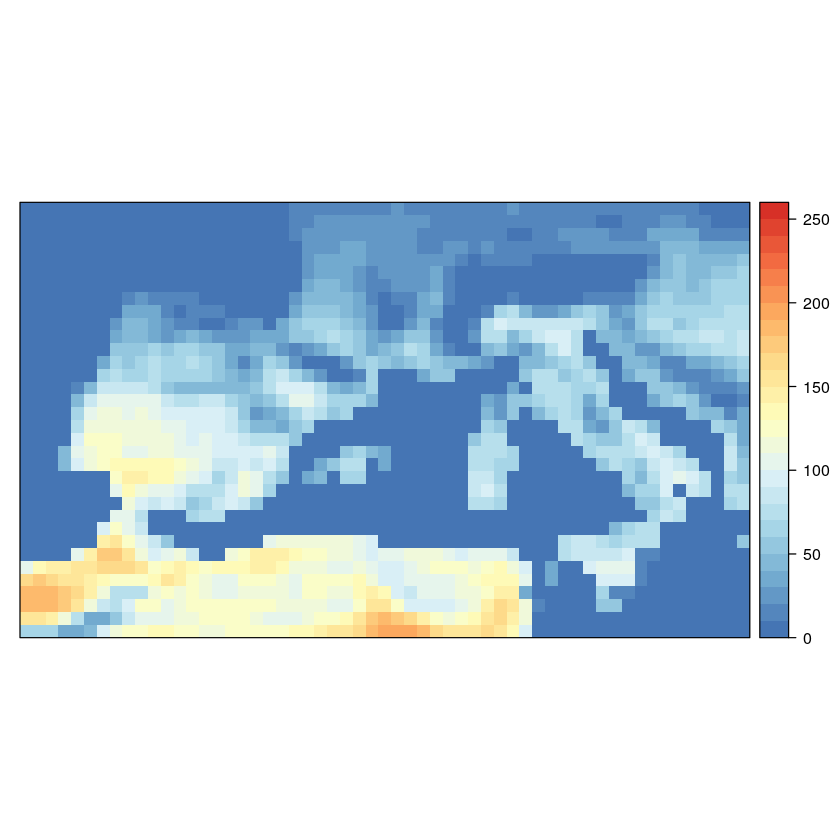

In [18]:
spatialPlot(climatology(SUh.annual), at = seq(0, 260, 10), 
            col.regions = colorRampPalette(colsindex))

As can be noted in Figure \ref{fig:fig2b}, the spatial grid of CORDEX is different from E-OBS (Figure \ref{fig:fig2a}). We can use function `interpGrid` to interpolate CORDEX data to the E-OBS spatial grid, allowing the subsequent extraction of the SU bias in the reference period (1971-2000). This is done by subtracting the SU index of E-OBS (object `SU.annual`) to the SU index of historical CORDEX (object `SUh.interp`), for which function `gridArithmetics` is used. 
Despite not being necessary, here we apply a land mask before calculating the bias in order to eliminate the values projected by the CORDEX model over the sea. To do so, `gridArithmetics` might be also used, first to create the mask and second to apply it.

In [19]:
SUh.interp <- interpGrid(SUh.annual, getGrid(SU.annual))
eobs.mask <- gridArithmetics(SU.annual, 0, operator = "*")
SUh.interp <- gridArithmetics(SUh.interp, eobs.mask, operator = "+")

bias <- gridArithmetics(SUh.interp, SU.annual, operator = "-")

NOTE: argument 'bilin.method' ignored for nearest neighbour interpolation
[2018-12-13 13:01:09] Calculating nearest neighbors...
[2018-12-13 13:01:09] Performing nearest interpolation... may take a while
[2018-12-13 13:01:09] Done


Next we plot the SU index for CORDEX (object `SUh.interp`) and its bias (object `bias`) to generate Figures \ref{fig:fig2c} and \ref{fig:fig2d} (Figs. 2c and 2d in the manuscript).

[2018-12-13 13:01:36] - Computing climatology...
[2018-12-13 13:01:36] - Done.


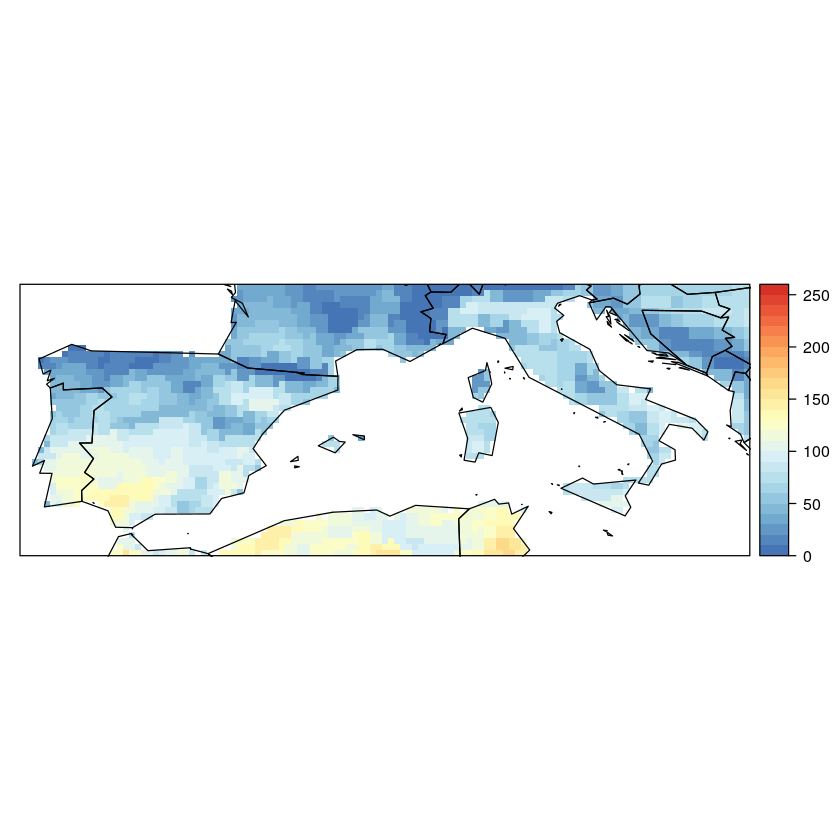

In [20]:
spatialPlot(climatology(SUh.interp), backdrop.theme = "countries", 
            at = seq(0, 260, 10), col.regions = colorRampPalette(colsindex))

[2018-12-13 13:01:41] - Computing climatology...
[2018-12-13 13:01:41] - Done.


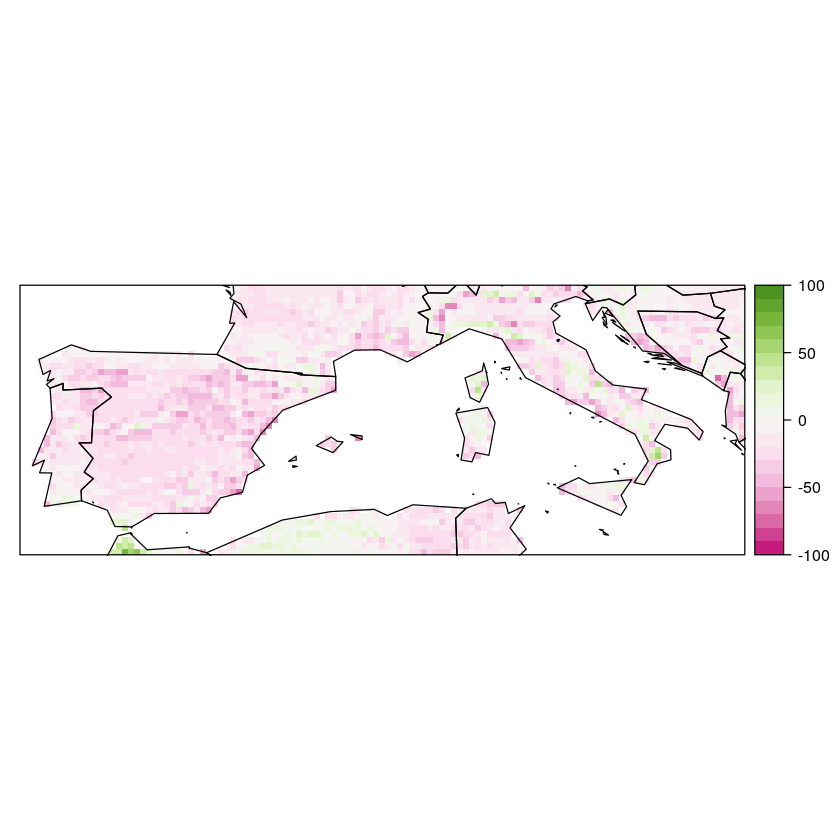

In [21]:
spatialPlot(climatology(bias), backdrop.theme = "countries", 
            at = seq(-100, 100, 10), col.regions = colorRampPalette(colsbias))

#### Future data

We repeat the same operations of data loading and transformation but for the RCP8.5 scenario and future period 2071-2100:

In [33]:
SUf <- loadGridData(dataset = "local_nc_data/rcp85/CDX_rcp85.ncml",
                     var = "tasmax",
                     season = 1:12,
                     lonLim = lon,
                     latLim = lat,
                     years = 2071:2100,
                     aggr.m = "sum", 
                     threshold = 25,
                     condition = "GT",
                     dictionary = "local_nc_data/dicCDX.dic")

[2018-12-13 13:07:07] Defining harmonization parameters for variable "tasmax"
[2018-12-13 13:07:07] Defining geo-location parameters
[2018-12-13 13:07:07] Defining time selection parameters
NOTE: Daily data will be monthly aggregated
[2018-12-13 13:07:07] Retrieving data subset ...
[2018-12-13 13:07:19] Done


In [34]:
SUf.annual <- aggregateGrid(SUf, aggr.y = list(FUN = "sum"))
str(SUf)

[2018-12-13 13:07:32] Performing annual aggregation...
[2018-12-13 13:07:32] Done.


List of 4
 $ Variable:List of 2
  ..$ varName: chr "Frequency Index"
  ..$ level  : NULL
  ..- attr(*, "use_dictionary")= logi TRUE
  ..- attr(*, "description")= chr "tasmax-based threshold exceedance count index"
  ..- attr(*, "units")= chr "days"
  ..- attr(*, "longname")= chr "Number of days when tasmax > 25 degC"
  ..- attr(*, "daily_agg_cellfun")= chr "none"
  ..- attr(*, "monthly_agg_cellfun")= chr "sum"
  ..- attr(*, "verification_time")= chr "none"
 $ Data    : num [1:360, 1:34, 1:57] 0 0 0 0 3 24 30 31 21 0 ...
  ..- attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
 $ xyCoords:List of 4
  ..$ x  : num [1:57] -22.9 -22.5 -22.1 -21.6 -21.2 ...
  ..$ y  : num [1:34] -15.7 -15.3 -14.9 -14.4 -14 ...
  ..$ lon: num [1:34, 1:57] -7.94 -8.12 -8.31 -8.49 -8.68 ...
  ..$ lat: num [1:34, 1:57] 31 31.4 31.8 32.2 32.6 ...
  ..- attr(*, "projection")= chr "RotatedPole"
  ..- attr(*, "resX")= num 0.44
  ..- attr(*, "resY")= num 0.44
  ..- attr(*, "resLON")= logi NA
  ..- attr(*, "resLAT")

Note that in this case the application of `gridArithmetics` gives the projected climate change signal (object `CCsignal`) w.r.t the historical period (object `SUh.interp`).

In [35]:
SUf.interp <- interpGrid(SUf.annual, getGrid(SU.annual))
SUf.interp <- gridArithmetics(SUf.interp, eobs.mask, operator = "+")

CCsignal <- gridArithmetics(SUf.interp, 
                            SUh.interp,
                            operator = "-")

NOTE: argument 'bilin.method' ignored for nearest neighbour interpolation
[2018-12-13 13:07:49] Calculating nearest neighbors...
[2018-12-13 13:07:50] Performing nearest interpolation... may take a while
[2018-12-13 13:07:50] Done


By plotting the resulting objects we obtain Figures \ref{fig:fig3c} (Fig. 3c in the manuscript) and \ref{fig:fig3d} (not shown in the manuscript):  

[2018-12-13 13:09:09] - Computing climatology...
[2018-12-13 13:09:09] - Done.


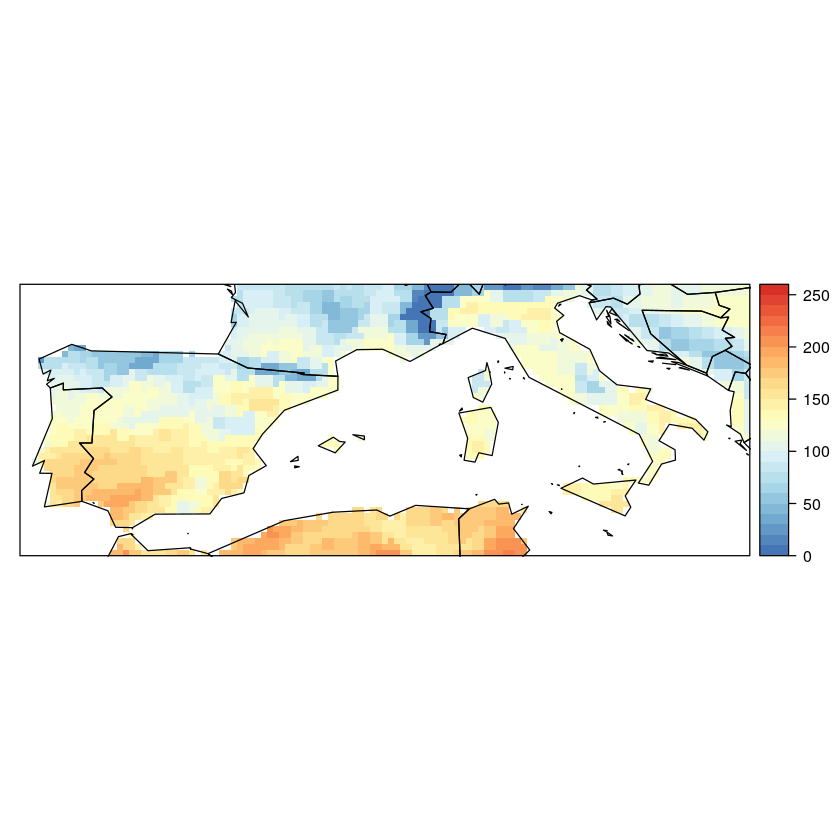

In [37]:
spatialPlot(climatology(SUf.interp), backdrop.theme = "countries", 
            at = seq(0, 260, 10), col.regions = colorRampPalette(colsindex))

[2018-12-13 13:09:20] - Computing climatology...
[2018-12-13 13:09:20] - Done.


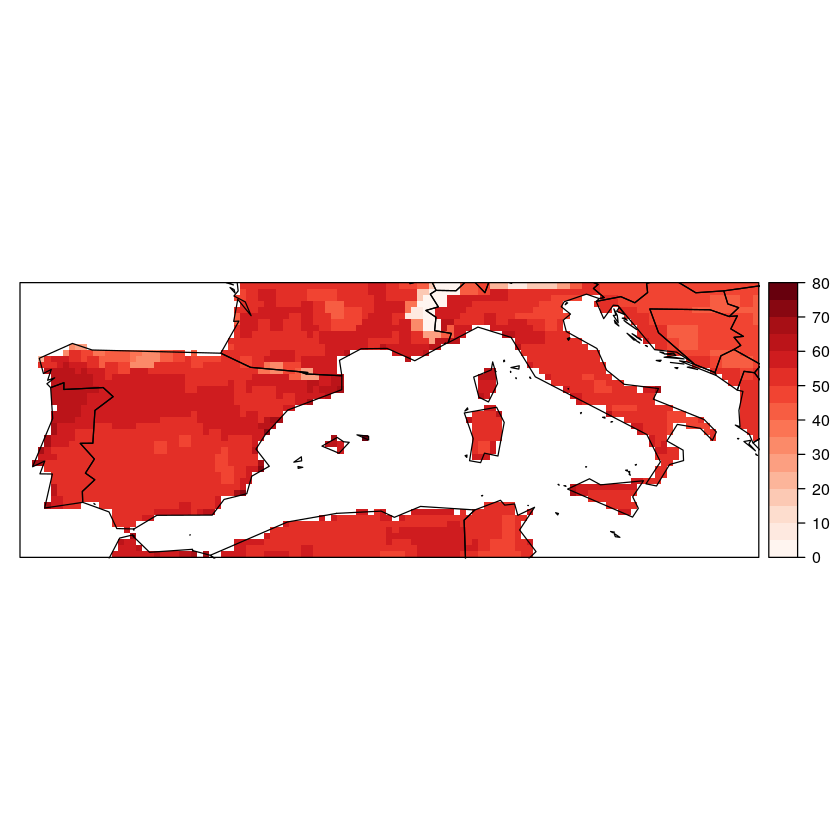

In [38]:
spatialPlot(climatology(CCsignal), backdrop.theme = "countries",
            at = seq(0, 80, 5), col.regions = colorRampPalette(colsdelta))

## Post-processing: Bias Correction

Next the "additive" type of the "scaling" method is applied to bias correct future monthly CORDEX data (object `SUf`) by means of function `biasCorrection`. The output is annually aggregated (object `SUf.bc.annual`) and the climate change signal is again calculated from the bias corrected data (object `CCsignal.bc`). 


In [39]:
SUf.bc <- biasCorrection(y = SU, x = SUh, newdata = SUf, 
                         method = "scaling", scaling.type = "additive")
SUf.bc.annual <- aggregateGrid(SUf.bc, aggr.y = list(FUN = "sum"))
CCsignal.bc <- gridArithmetics(SUf.bc.annual, 
                            SU.annual,
                            operator = "-")

[2018-12-13 13:09:44] Argument precipitation is set as FALSE, please ensure that this matches your data.
[2018-12-13 13:09:45] Number of windows considered: 1...
[2018-12-13 13:09:45] Bias-correcting 1 members separately...
[2018-12-13 13:09:46] Done.
[2018-12-13 13:09:46] Performing annual aggregation...
[2018-12-13 13:09:47] Done.


By plotting the resulting objects we obtain Figures \ref{fig:fig3c} (Fig. 3c in the manuscript) and \ref{fig:fig3d} (not shown in the manuscript):  

[2018-12-13 13:10:21] - Computing climatology...
[2018-12-13 13:10:21] - Done.


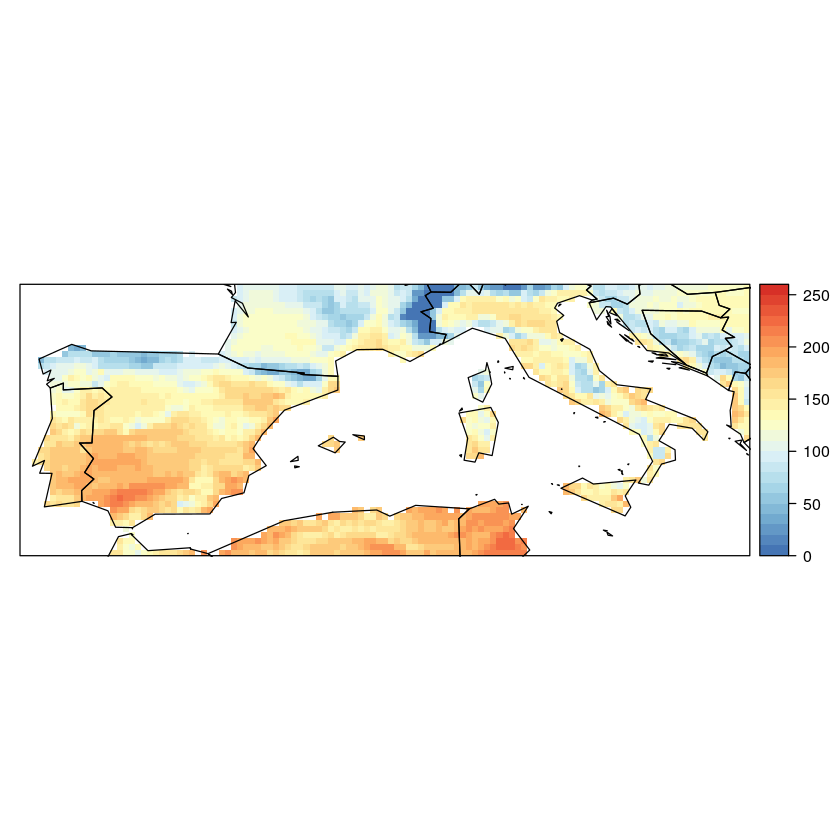

In [40]:
spatialPlot(climatology(SUf.bc.annual), backdrop.theme = "countries", 
            at = seq(0, 260, 10), col.regions = colorRampPalette(colsindex))

[2018-12-13 13:10:32] - Computing climatology...
[2018-12-13 13:10:32] - Done.


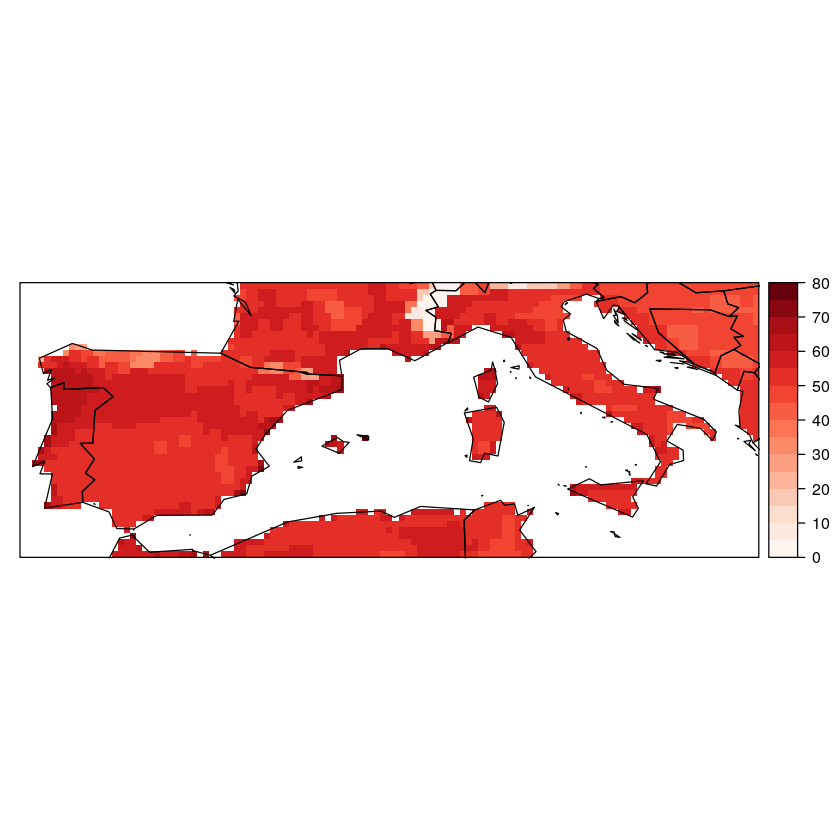

In [41]:
spatialPlot(climatology(CCsignal.bc), backdrop.theme = "countries",
            at = seq(0, 80, 5), col.regions = colorRampPalette(colsdelta))

Other useful plotting function is `temporalPlot` that displays temporal series of multiple datasets
and periods on the same plot. Here we plot the series corresponding to a single grid box (`latLim = 41.64`, `lonLim = -0.89`). If several grid boxes are considered (e.g. the whole domain) `temporalPlot` performs the spatial (`lat` and `lon` dimensions) aggregation before plotting (the `mean` is computed by default, type `?temporalPlot`).

Note that function `temporalPlot` is based on `lattice` and arguments from function `xyplot` are optionally passed to argument `xyplot.custom`, allowing for a fine tuning of multiple graphical parameters. The next code chunk generates Figure \ref{fig:fig4} (Fig. 4 in the manuscript).

pad applied on the interval: year
pad applied on the interval: year
pad applied on the interval: year
pad applied on the interval: year


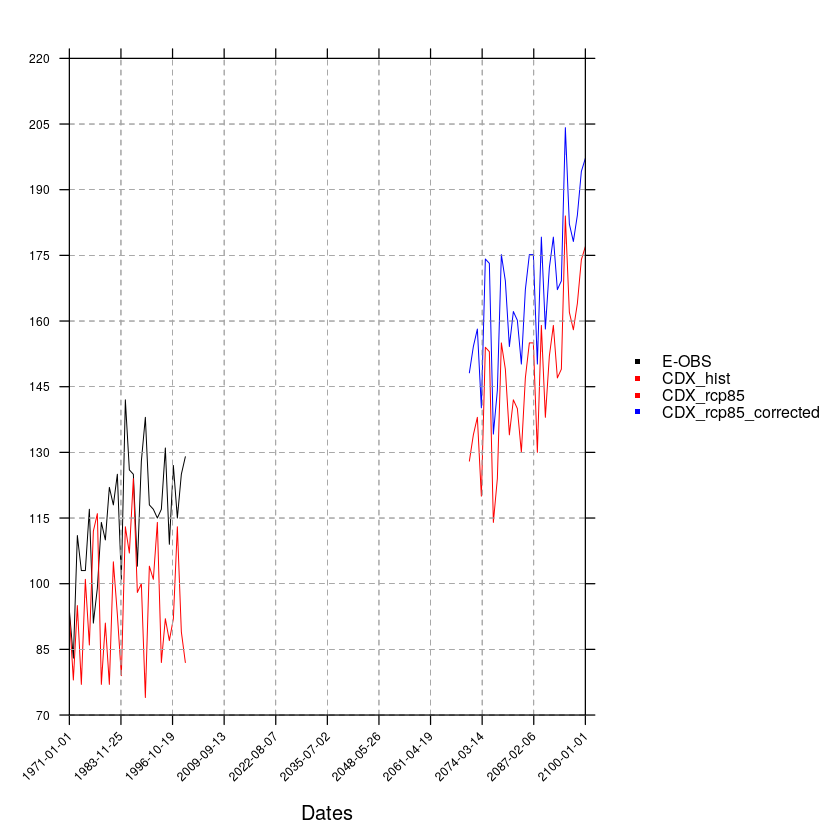

In [42]:
cols = c("black", "red", "red", "blue")
temporalPlot("E-OBS" = SU.annual, 
             "CDX_hist" = SUh.interp, 
             "CDX_rcp85" = SUf.interp, 
             "CDX_rcp85_corrected" = SUf.bc.annual, 
             latLim = 41.64, lonLim = -0.89, 
             cols = cols, lwd = 0.8, 
             xyplot.custom = list(ylab = "", ylim = c(70, 220)))

In [44]:
rm(list = c("SU", "SU.annual", "SUh", "SUh.annual", "SUh.interp", "SUf", "SUf.interp", "SUf.annual", "SUf.bc", "SUf.bc.annual", "CCsignal", "CCsignal.bc", "bias"))

Warning message in rm(list = c("SU", "SU.annual", "SUh", "SUh.annual", "SUh.interp", :
“object 'SU' not found”Warning message in rm(list = c("SU", "SU.annual", "SUh", "SUh.annual", "SUh.interp", :
“object 'SU.annual' not found”Warning message in rm(list = c("SU", "SU.annual", "SUh", "SUh.annual", "SUh.interp", :
“object 'SUh' not found”Warning message in rm(list = c("SU", "SU.annual", "SUh", "SUh.annual", "SUh.interp", :
“object 'SUh.annual' not found”Warning message in rm(list = c("SU", "SU.annual", "SUh", "SUh.annual", "SUh.interp", :
“object 'SUh.interp' not found”Warning message in rm(list = c("SU", "SU.annual", "SUh", "SUh.annual", "SUh.interp", :
“object 'SUf' not found”Warning message in rm(list = c("SU", "SU.annual", "SUh", "SUh.annual", "SUh.interp", :
“object 'SUf.interp' not found”Warning message in rm(list = c("SU", "SU.annual", "SUh", "SUh.annual", "SUh.interp", :
“object 'SUf.annual' not found”Warning message in rm(list = c("SU", "SU.annual", "SUh", "SUh.annual", "SUh.int

## Working with daily data

Alternatively, the SU index could be calculated using the `climate4R.climdex` package from the original variable (maximum temperature). To do so, we first load daily maximum temperature data by using the previously created dictionaries:

In [45]:
TX <- loadGridData(eobs,
                   var = "tasmax",
                     season = 1:12,
                         lonLim = lon,
                         latLim = lat,
                         years = 1971:2000,
                         dictionary = "dicEOBS.dic")
TXh <- loadGridData(dataset = "CDX_hist.ncml",
                     var = "tasmax",
                     season = 1:12,
                     lonLim = lon,
                     latLim = lat,
                     years = 1971:2000,
                     dictionary = "dicCDX.dic")
TXf <- loadGridData(dataset = "CDX_rcp85.ncml",
                     var = "tasmax",
                     season = 1:12,
                     lonLim = lon,
                     latLim = lat,
                     years = 2071:2100,
                     dictionary = "dicCDX.dic")

[2018-12-13 13:12:10] Defining harmonization parameters for variable "tasmax"
[2018-12-13 13:12:11] Opening dataset...
[2018-12-13 13:12:12] The dataset was successfuly opened
[2018-12-13 13:12:12] Defining geo-location parameters
[2018-12-13 13:12:12] Defining time selection parameters
[2018-12-13 13:12:12] Retrieving data subset ...
[2018-12-13 13:18:19] Done
[2018-12-13 13:18:19] Defining harmonization parameters for variable "tasmax"
[2018-12-13 13:18:19] Defining geo-location parameters
[2018-12-13 13:18:19] Defining time selection parameters
[2018-12-13 13:18:19] Retrieving data subset ...
[2018-12-13 13:18:26] Done
[2018-12-13 13:18:26] Defining harmonization parameters for variable "tasmax"
[2018-12-13 13:18:27] Defining geo-location parameters
[2018-12-13 13:18:27] Defining time selection parameters
[2018-12-13 13:18:27] Retrieving data subset ...
[2018-12-13 13:18:32] Done


Since we are now working with daily data, we can use the EQM (Empirical Quantile Mapping) method to bias correct the original variable. As pointed in the previous section, CORDEX projections are built over rotated grids. Nevertheless, function `biasCorrection` performs data interpolation internally taking as spatial reference the grid of observation data (E-OBS, object `TX`). Therefore, it is not necessary to use `interpGrid` before applying `biasCorrection`. 

In [46]:
TXf.bc <- biasCorrection(y = TX, 
                         x = TXh, 
                         newdata = TXf, 
                         method = "eqm",
                         window = c(30, 7), 
                         extrapolation = "constant")

[2018-12-13 13:25:03] Argument precipitation is set as FALSE, please ensure that this matches your data.
[2018-12-13 13:27:50] Number of windows considered: 52...
[2018-12-13 13:27:50] Bias-correcting 1 members separately...
[2018-12-13 13:34:04] Done.


Next, we calculate the annual SU index with function `climdexGrid` for future raw (object `SUf`) and bias corrected (object `SUf.bc`) CORDEX data:

In [47]:
SUf <- climdexGrid(tx = TXf, index.code = "SU")
SUf.bc <- climdexGrid(tx = TXf.bc, index.code = "SU")

[2018-12-13 15:51:00] Calculating SU ...
[2018-12-13 15:51:38] Done
[2018-12-13 15:51:40] Calculating SU ...
[2018-12-13 15:52:39] Done


To obtain comparable maps and/or perform further operations between the obtained results (e.g. using `gridArithmetics`), we can interpolate the raw SU index (function `interpGrid`) to the E-OBS spatial grid and apply the land-sea mask (function `gridArithmetics`) in the manner previously shown:

In [48]:
SUf.interp <- interpGrid(SUf, getGrid(TX))
SUf.interp <- gridArithmetics(SUf.interp, eobs.mask, operator = "+")

NOTE: argument 'bilin.method' ignored for nearest neighbour interpolation
[2018-12-13 15:53:58] Calculating nearest neighbors...
[2018-12-13 15:53:58] Performing nearest interpolation... may take a while
[2018-12-13 15:53:58] Done


Finally, the maps of raw and bias corrected SU index for the EC-EARTH driven, RCP8.5 scenario (period 2071-2100) are plotted, resulting in Figures \ref{fig:fig5a} (Not shown in the manuscript) and \ref{fig:fig5} (Fig. 5 in the manuscript).

[2018-12-13 15:54:03] - Computing climatology...
[2018-12-13 15:54:03] - Done.


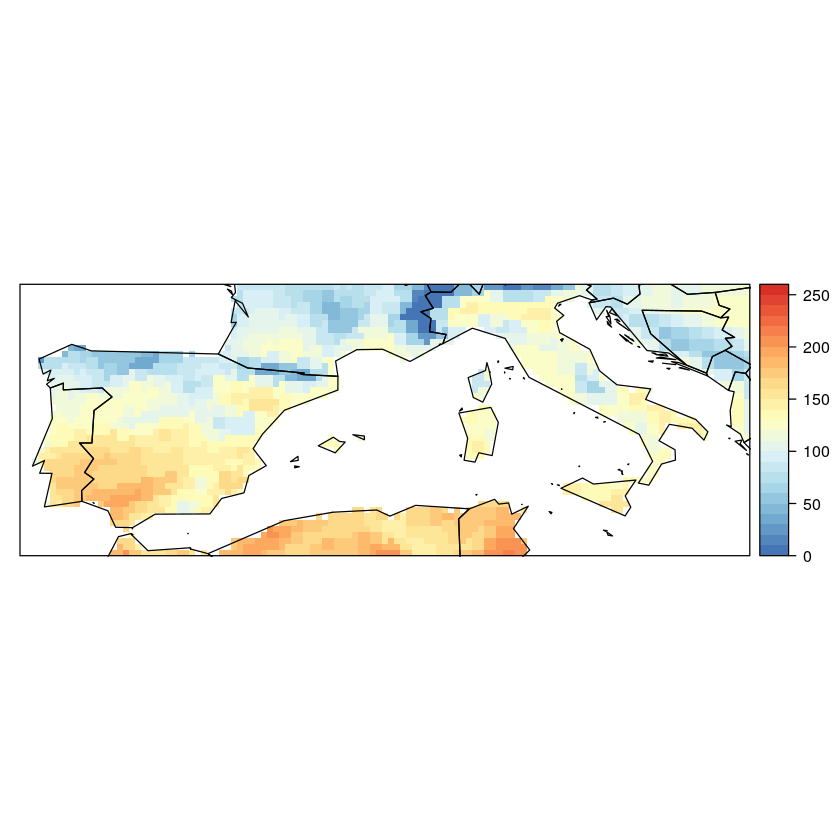

In [49]:
spatialPlot(climatology(SUf.interp), backdrop.theme = "countries", 
            at = seq(0, 260, 10), col.regions = colorRampPalette(colsindex))

[2018-12-13 15:54:12] - Computing climatology...
[2018-12-13 15:54:12] - Done.


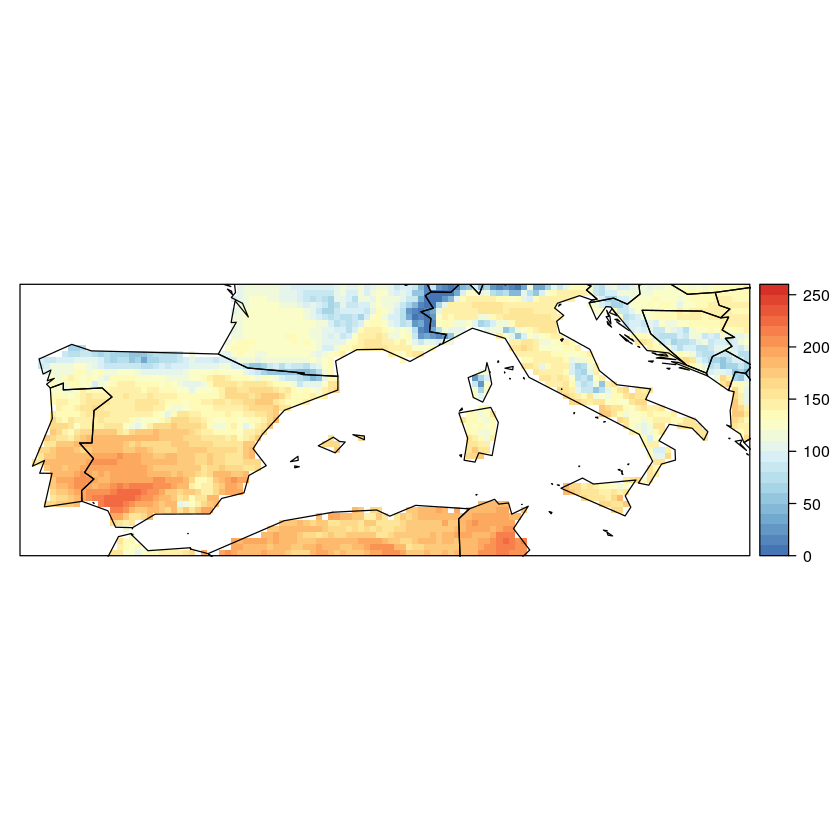

In [50]:
spatialPlot(climatology(SUf.bc), backdrop.theme = "countries", 
            at = seq(0, 260, 10), col.regions = colorRampPalette(colsindex))

In [51]:
rm(list = c("TX","TXh", "TXf", "TXf.bc", "SUf", "SUf.bc"))

# Other available material

* [2018_climate4R_example2.pdf](https://github.com/SantanderMetGroup/notebooks/blob/devel/2018_climate4R_example2.pdf) contains the full code for **Example 2** of the paper `climate4R: An Ecosystem of R packages for Climate Data Access, Post-processing and Bias Correction'.
* Find more worked examples on the utilization of climate4R packages in their respective GitHub **wiki**-s at [https://github.com/SantanderMetGroup](https://github.com/SantanderMetGroup):
    + [loadeR: https://github.com/SantanderMetGroup/loadeR/wiki](https://github.com/SantanderMetGroup/loadeR/wiki)
    + [transformeR: https://github.com/SantanderMetGroup/transformeR/wiki](https://github.com/SantanderMetGroup/transformeR/wiki)
    + [downscaleR: https://github.com/SantanderMetGroup/downscaleR/wiki](https://github.com/SantanderMetGroup/downscaleR/wiki)
    + [visualizeR: https://github.com/SantanderMetGroup/visualizeR/wiki](https://github.com/SantanderMetGroup/visualizeR/wiki) 
